<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/EVA_session_2_5_Assignment/EVA_Session_2_5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breaking the code down into 3 problems:
1. CNN based MNIST prediction
2. Vanilla NN based sum prediction
3. Combining MNIST and Random Number prediction into a unified network

### 1. Only MNIST prediction through a CNN

In [4]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F


In [5]:
!pip install GPUtil
import GPUtil 
GPUtil. getAvailable()
import torch 
use_cuda = torch. cuda. is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=317e56b46644c2baae0dd858ad05005c3c493c855cb59dfe9ae7955acb1da2e7
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil
__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.843721216


In [6]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [9]:
example_data.shape

torch.Size([1000, 1, 28, 28])

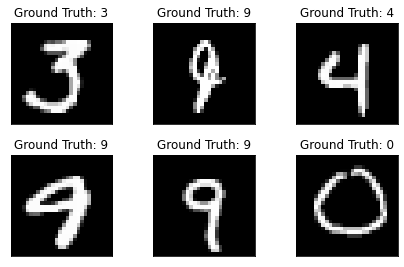

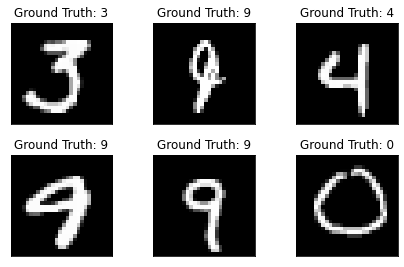

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # convolution layer with 32 of 3*3 kernels. 1*28*28 (1*30*30 with padding) - 32*28*28 - RF = 3*3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # convolution layer with 64 of 3*3 kernels.  32*28*28 (1*30*30 with padding) - 64*28*28 - RF = 5*5
        self.pool1 = nn.MaxPool2d(2, 2) # max pooling using a 2*2 kernel. 64*28*28 - 64*14*14 - RF = 10*10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # convolution layer with 128 of 3*3 kernels.  64*14*14 (64*16*16 with padding) - 128*14*14 - RF = 12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # convolution layer with 256 of 3*3 kernels.  128*14*14 (128*16*16 with padding) - 256*14*14 - RF = 14*14
        self.pool2 = nn.MaxPool2d(2, 2) # max pooling using a 2*2 kernel. 256*14*14 - 256*7*7 - RF = 28*28
        self.conv5 = nn.Conv2d(256, 512, 3)# convolution layer with 512 of 3*3 kernels.  256*7*7 - 512*5*5 - RF = 30*30 (larger than image size?)
        self.conv6 = nn.Conv2d(512, 1024, 3)# convolution layer with 1024 of 3*3 kernels.  512*5*5 - 1024*3*3 - RF = 32*32 (larger than image size?)
        self.conv7 = nn.Conv2d(1024, 10, 3)# convolution layer with 10 of 3*3 kernels.  1024*3*3 - 10*1*1 - RF = 34*34 (larger than image size?)
    def forward(self, x): # module to implement the sequential neural network
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))) # sequence of conv1 taking input imagge and output activated by rely, passes to conv2 activated by relu and pooled. 
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))) # sequence of taking above output and passing to conv3 and output activated by rely, passes to conv4 activated by relu and pooled. 
        x = F.relu(self.conv6(F.relu(self.conv5(x)))) # sequence of taking above output and passing to conv5 and output activated by relu. passes to conv6 and activated by relu.
        x = self.conv7(x)# sequence of taking above output and passing to conv7 and output activated by relu
        x = x.view(-1, 10) # flattening the output to 1-d (original vs. addition of lin)
        return F.log_softmax(x) # return the logged softmax of the 1-d

In [12]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [13]:
example_data[0].shape

torch.Size([1, 28, 28])

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [15]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

In [16]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [17]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-11-5dd3686f6f5e>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # return the logged softmax of the 1-d
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3022, Accuracy: 1090/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303934
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300914
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298610
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.296788
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.291762
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.289384
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.284298
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.276219
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.272397
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.266490
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.236381
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.205398
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.067671
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.804862
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.061278
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.925063
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.828784
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.822502
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.616835
Train Epoch: 1 [12160

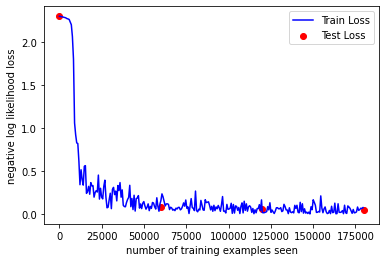

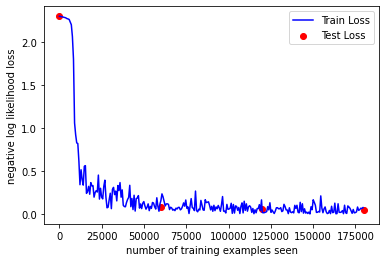

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

### Linear addition through a vanilla neural network

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Add layers here
        self.fc1 = nn.Linear(2, 1)  # 2 input units, 1 output unit

    def forward(self, x):
        # Define the forward pass here
        x = self.fc1(x)
        return x
net = Net()

NameError: ignored

In [3]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)


NameError: ignored

In [ ]:
# Convert data to tensors
X = torch.Tensor([[2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]])
y = torch.Tensor([[5], [7], [9], [11], [13], [15]])

# Train the model
for epoch in range(10):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()


In [ ]:
input_set = [8,9]
x_test = torch.Tensor([input_set])
y_pred = net(x_test)
print(y_pred)  
print(sum(input_set))

In [ ]:
input_set = [18,91]
x_test = torch.Tensor([input_set])
y_pred = net(x_test)
print(y_pred)  
print(sum(input_set))

### 3. combining the MNIST prediction with sum prediction

In [ ]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(3 * 3 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x, y):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.view(-1, 3 * 3 * 64)
        x = self.fc1(x)
        x = torch.relu(x)
        digit_prediction = self.fc2(x)
        sum_prediction = self.fc3(x) + y
        return digit_prediction, sum_prediction


In [ ]:
model = MNISTModel()
x = torch.randn(64, 28, 28)  # batch of MNIST images
y = torch.randn(64, 1)  # batch of random numbers
digit_prediction, sum_prediction = model(x, y)
